<a href="https://colab.research.google.com/github/LNWork/Auslan-sign-app/blob/model/CNN_LSTM_model_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Masking
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import glob
import json
import time

In [ ]:
import re
# test test test

def check_list_contained(A, B):
  # convert list A to string
    A_str = ' '.join(map(str, A))
    # convert list B to string
    B_str = ' '.join(map(str, B))
    # find all instances of A within B
    instances = re.findall(A_str, B_str)

    # return True if any instances were found, False otherwise
    return len(instances) > 0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
SSD_PATH = '/content/gdrive/MyDrive/Auslan App/Data'


In [ ]:
%cd $SSD_PATH
%pwd

/content/gdrive/MyDrive/Auslan App/Data


'/content/gdrive/MyDrive/Auslan App/Data'

In [ ]:
%%capture
!unzip json_keypoints.zip -d /images_first_json

Archive:  json_keypoints.zip
   creating: /images_first_json/json_keypoints/
  inflating: /images_first_json/json_keypoints/1000_keypoints.json  
  inflating: /images_first_json/json_keypoints/1001_keypoints.json  
  inflating: /images_first_json/json_keypoints/1002_keypoints.json  
  inflating: /images_first_json/json_keypoints/1003_keypoints.json  
  inflating: /images_first_json/json_keypoints/1004_keypoints.json  
  inflating: /images_first_json/json_keypoints/1005_keypoints.json  
  inflating: /images_first_json/json_keypoints/1006_keypoints.json  
  inflating: /images_first_json/json_keypoints/1007_keypoints.json  
  inflating: /images_first_json/json_keypoints/1008_keypoints.json  
  inflating: /images_first_json/json_keypoints/1009_keypoints.json  
  inflating: /images_first_json/json_keypoints/100_keypoints.json  
  inflating: /images_first_json/json_keypoints/1010_keypoints.json  
  inflating: /images_first_json/json_keypoints/1011_keypoints.json  
  inflating: /images_first_

Need to get data in format of list of dataframe being the data where the index is same as label index.



In [ ]:
# Getting all the files for data
files = glob.glob('/images_first_json/json_keypoints/*')

# Getting the sheet of the signs
iso_sign_key = pd.read_excel('Isolated_Sign_Language_List.xlsx', index_col=None, usecols="B:D")

# check start time
start = time.time()

# Initialising the array for the test & train data
y_train = []
x_train = []

y_test = []
x_test = []

# Getting largest frames in the dataset to match all sizes
largest_frames = 0

# Going through all files
for file in files:
  # Getting JSON file
  with open(file, 'r') as f:
    # Reading JSON file and converting it to dict type
    d = f.read()
    vid_data = json.loads(d)

    # Getting video id to match with the name
    id = file.split("/")[-1].split('_')[0]
    id = 1 if id == "f'{video" else id # Checker for missing video id 1

    # Get Key points in dataframe format for the next step
    data = []
    for frame in vid_data:
        # Checks if not all the land_marks are there, skip frame if yes
        if not check_list_contained(['pose_landmarks', 'left_hand_landmarks', 'right_hand_landmarks'], frame.keys()):
          #print('failed', frame['frame'])
          continue

        # Appending whole frame data to the temp variable
        f_data = pd.DataFrame(frame['pose_landmarks'] + frame['left_hand_landmarks'] + frame['right_hand_landmarks'])
        data.append(f_data)

    if len(data) == 0:
      print(f"No complete data for {id}")
      continue

    # Making the dataframes in the same format
    combined_df = pd.concat(data, ignore_index=True)
    reshaped_data = combined_df.values.reshape((len(data), 75, 4))

    # Checking for largest frame
    largest_frames = len(data) if len(data) > largest_frames else largest_frames

    # Read the csv for the label and which split is goes into
    iso_row = iso_sign_key.loc[iso_sign_key['Video_ID'] == int(id)]
    word = iso_row["Gloss"].values[0]

    # cbs createing val data, only checking for test
    if "test" in iso_row["Split"].values:
      y_test.append(word)
      x_test.append(reshaped_data)
    else:
      y_train.append(word)
      x_train.append(reshaped_data)

# Printing total data and total time run
print("Train", len(x_train), len(y_train))
print("Test", len(x_test), len(y_test))
print(time.time() - start)

No complete data for 3044
No complete data for 127
No complete data for 905
No complete data for 236
No complete data for 1764
No complete data for 2434
No complete data for 920
No complete data for 3005
No complete data for 388
No complete data for 647
No complete data for 2048
No complete data for 726
No complete data for 2283
No complete data for 391
No complete data for 1384
No complete data for 941
No complete data for 1195
No complete data for 2987
No complete data for 426
No complete data for 3066
No complete data for 1100
No complete data for 519
No complete data for 3068
No complete data for 434
No complete data for 1105
No complete data for 491
No complete data for 2789
No complete data for 142
No complete data for 1565
No complete data for 767
No complete data for 1215
No complete data for 88
No complete data for 1406
No complete data for 3086
No complete data for 1032
No complete data for 2025
No complete data for 409
No complete data for 2043
No complete data for 1227
No c

In [ ]:
print(x_train[5].shape)
print(len(x_train))
print(largest_frames)

(6, 75, 4)
2522
136


In [ ]:
def pad_sequences(data, max_timesteps):
    padded_data = []
    for sequence in data:
        padding_needed = max_timesteps - sequence.shape[0]
        # Pad the sequence with zeros if it is shorter
        if padding_needed > 0:
            # Pad along the first axis (timesteps)
            padded_sequence = np.pad(sequence, ((0, padding_needed), (0, 0), (0, 0)), mode='constant')
        else:
            padded_sequence = sequence
        padded_data.append(padded_sequence)
    return np.array(padded_data)

# Pad train and test data
padded_train_data = pad_sequences(x_train, largest_frames)
padded_test_data = pad_sequences(x_test, largest_frames)

padded_train_data = padded_train_data[..., np.newaxis]
padded_test_data = padded_test_data[..., np.newaxis]

In [ ]:
# [Video [Frame [Keypoints]]]
print(padded_train_data.shape)
print(padded_test_data.shape)

timesteps, keypoints, features, outputs = padded_train_data.shape[1], padded_train_data.shape[2], padded_train_data.shape[3], 610


(2522, 136, 75, 4, 1)
(587, 136, 75, 4, 1)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode the labels (train and test labels)
train_labels = label_encoder.transform(y_train)  # Assuming these are your training labels
test_labels = label_encoder.transform(y_test)  # Assuming this is your test label

# One-hot encode the labels for use in categorical crossentropy
train_labels = to_categorical(train_labels, num_classes=outputs)
test_labels = to_categorical(test_labels, num_classes=outputs)

In [ ]:
# Why wer using conv2d when we now 3d data
# Pooling and dropout not needed atm
# Filp filter size end potin max 256
# Max total param ~5mill
# Read papers about the data format and the model they have used


model = Sequential()

# Finding Features
model.add(TimeDistributed(Conv2D(filters=1024, kernel_size=(5,5), activation='relu', padding='same'), input_shape=(timesteps, keypoints, features, 1)))
model.add(TimeDistributed(Conv2D(filters=512, kernel_size=(5,5), activation='relu', padding='same')))
model.add(TimeDistributed(Dropout(0.2))) # Small dropout to prevent overfitting
model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3)))) # To reduce the size to make it easier to work wit

model.add(TimeDistributed(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))) # More layer cause why not
model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))

# Connnect through time to find motion
model.add(LSTM(128))
model.add(Dropout(0.2))

# Classification
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 136, 75, 4, 1024)    │          26,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 136, 75, 4, 512)     │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 136, 75, 4, 512)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 136, 25, 1, 512)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 136, 25, 1, 256)     │       1,179,904 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 136, 25, 1, 128)     │         295,040 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 136, 12, 0, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 136, 0)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 610)                 │          39,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,746 (56.23 MB)

 Trainable params: 14,739,746 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback Functions:

# 1. Early Stopping: Stops training when a monitored metric has stopped improving, which helps to avoid overfitting.
early_stopping = EarlyStopping (
    monitor = 'val_accuracy', # Monitor validation loss
    patience = 10, # Number of epochs with no improvement after which training will be stopped
    verbose = 1, # Print messages
    restore_best_weights = True # Restore model weights from the epoch with the best validation loss
)

# 2. Model Checkpoint: Saves the model at specific intervals or when it achieves the best performance on the validation set.
model_checkpoint = ModelCheckpoint(
    filepath = '/content/gdrive/MyDrive/Auslan App/Model/Checkpoints/best_model.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

#3. Learning Rate Scheduler: Reduces the learning rate when the performance metric stops improving.
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2, # Factor by which the learning rate will be reduced
    patience = 10,
    verbose = 1
)

callbacks = [model_checkpoint]

In [ ]:
# Train model
history = model.fit(
    padded_train_data,
    train_labels,
    epochs=25,  # Adjust epochs based on your needs
    batch_size=8,  # You can adjust this depending on memory
    validation_data=(padded_test_data, test_labels),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/25


ValueError: Exception encountered when calling TimeDistributed.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_1_1/time_distributed_14_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_1_1/time_distributed_14_1/strided_slice_1)' with input shapes: [?,25,1,128].[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(None, 136, 25, 1, 128), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Evaluate on test data
model.evaluate(padded_test_data, test_labels)

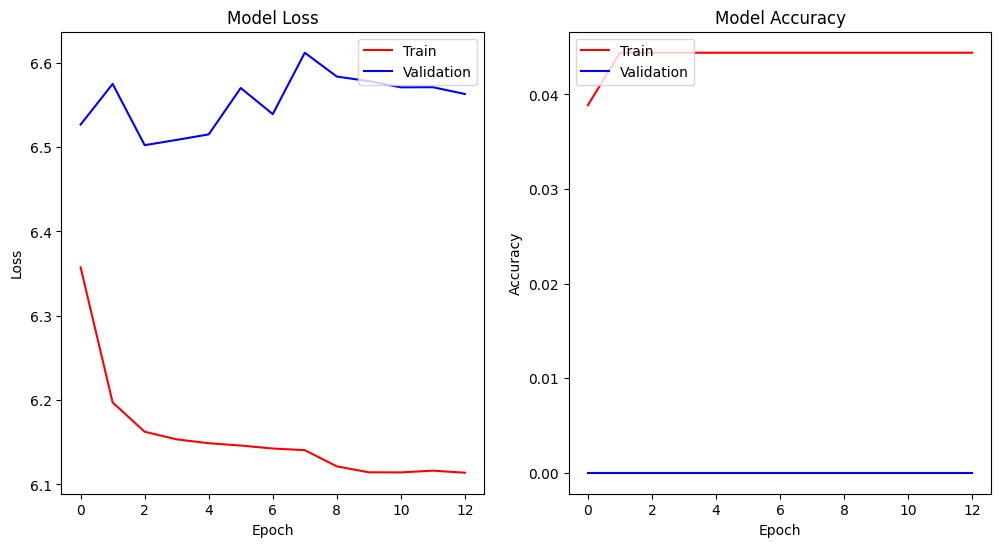

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test data
y_pred = model.predict(padded_test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=words, yticklabels=words)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 449ms/step


NameError: name 'words' is not defined

<Figure size 800x600 with 0 Axes>